In [183]:
import pandas as pd
from datetime import datetime, timedelta, date
df = pd.read_excel('/Users/sandaz/Downloads/COVID-19 US state policy database 11_22_2021.xlsx')

In [188]:
masks_mandate_school = [['FMSCHOOL', 'TODAY']]
masks_mandate_ban = [['FMSCHOOLBAN', 'TODAY']]
bars_closing = [['CLOSEBAR', 'END_BRS'], [['CLBAR2', 'BCLBAR2'], 'END_BRS2'], ['CLBAR3', 'END_CLBAR3']]
restaurants_closing = [['CLREST', 'ENDREST'], ['CLRST2', 'ENDREST2'], ['CLRST3', 'END_CLRST3']]
mask_mandate = [['FM_ALL', ['FM_END', 'FMENDVAX', 'FM_END2']], ['FMVAX', ['FM_END', 'FMENDVAX', 'FM_END2']], ['FM_ALL2', 'FM_END2']]

In [189]:
def fill_dates(start_end_tuple):
    start_date = start_end_tuple[0]
    end_date = start_end_tuple[1] if pd.notnull(start_end_tuple[1]) else date.today()
    if pd.notnull(start_date):
        delta = end_date - start_date   # returns timedelta
        return [start_date + timedelta(days=i) for i in range(delta.days + 1)]
    else:
        return []
    
states = df.STATE[4:].reset_index(drop=True).to_list()
states.remove('District of Columbia')
keys = pd.DataFrame({'state': states, 'date': pd.Series([(date(2020,3,1), date.today()) for i in range(len(states))]).apply(fill_dates)}).explode('date')

In [354]:
def get_sequence_for_eles(eles):
    seq = df[eles[0]]
    seq[seq==0] = None
    for ele in eles:
        potential_seq = df[ele]
        potential_seq[seq==0] = None
        seq.combine_first(potential_seq)
    return seq[4:]


        
def get_intervention_ts(intervention_cols, ts_name):
    result = []
    for int_ele in intervention_cols:
        start_int = int_ele[0] if isinstance(int_ele[0], list) else [int_ele[0]]
        end_int = int_ele[1] if isinstance(int_ele[1], list) else [int_ele[1]]
        start_int_date = pd.to_datetime(get_sequence_for_eles(start_int)).dt.date
        end_int_date = pd.to_datetime(get_sequence_for_eles(end_int)).dt.date
        timeseries = pd.Series(zip(start_int_date, end_int_date)).apply(fill_dates)
        ts_df = pd.DataFrame({'state':df.STATE[4:].reset_index(drop=True), 'date' : timeseries}).explode('date')
        ts_df = ts_df[pd.notnull(ts_df['date'])]
        result.append(ts_df)
    result = pd.concat(result).drop_duplicates()
    result[ts_name] = 1
    result = pd.merge(result, keys, on=['state', 'date'], how='right').fillna(0)
    
    return result
        
    
masks = get_intervention_ts(mask_mandate, 'mask_mandate')
bars = get_intervention_ts(bars_closing, 'bar_closed')
rest = get_intervention_ts(restaurants_closing, 'restaurant_closed')
masks_school = get_intervention_ts(masks_mandate_school, 'masks_in_school')
masks_ban = get_intervention_ts(masks_mandate_ban, 'mask_mandates_banned')


nlp_intervention_df = pd.merge(masks, bars, on=['state', 'date'], how='inner')
nlp_intervention_df = pd.merge(nlp_intervention_df, rest, on=['state', 'date'], how='inner')
nlp_intervention_df = pd.merge(nlp_intervention_df, masks_school, on=['state', 'date'], how='inner')
nlp_intervention_df = pd.merge(nlp_intervention_df, masks_ban, on = ['state', 'date'], how = 'inner')
nlp_intervention_df
#masks_ban

/var/folders/ch/f2xwy91d04vcjzw6nx_91qpw0000gs/T/ipykernel_47513/2296960906.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seq[seq==0] = None
/var/folders/ch/f2xwy91d04vcjzw6nx_91qpw0000gs/T/ipykernel_47513/2296960906.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  potential_seq[seq==0] = None
/var/folders/ch/f2xwy91d04vcjzw6nx_91qpw0000gs/T/ipykernel_47513/2296960906.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seq[seq

,state,date,mask_mandate,bar_closed,restaurant_closed,masks_in_school,mask_mandates_banned
0,Alabama,2020-03-01,0.0,0.0,0.0,0.0,0.0
1,Alabama,2020-03-02,0.0,0.0,0.0,0.0,0.0
2,Alabama,2020-03-03,0.0,0.0,0.0,0.0,0.0
3,Alabama,2020-03-04,0.0,0.0,0.0,0.0,0.0
4,Alabama,2020-03-05,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
32795,Wyoming,2021-12-12,0.0,0.0,0.0,0.0,0.0
32796,Wyoming,2021-12-13,0.0,0.0,0.0,0.0,0.0
32797,Wyoming,2021-12-14,0.0,0.0,0.0,0.0,0.0
32798,Wyoming,2021-12-15,0.0,0.0,0.0,0.0,0.0


In [355]:
gov_approval_df = pd.read_csv('/Users/sandaz/Downloads/Executive Approval.csv')
gov_approval_df = gov_approval_df[gov_approval_df.State != 'United States']
gov_approval_df = gov_approval_df[gov_approval_df.State != "District of Columbia"]
dates = pd.Series(zip(gov_approval_df.Start_Date.apply(pd.to_datetime).dt.date, gov_approval_df.End_Date.apply(pd.to_datetime).dt.date)).apply(fill_dates)
gov_approval_df = pd.DataFrame({'state': gov_approval_df.State.reset_index(drop=True), 'date': dates, 'govenor_approval': gov_approval_df['Your State Governor'].reset_index(drop=True)}).explode('date')
gov_approval_keys = pd.DataFrame({'state': states, 'date': [fill_dates((gov_approval_df.date.unique()[0], gov_approval_df.date.unique()[-1])) for i in range(len(states))]}).explode('date')
gov_approval_df = pd.merge(gov_approval_df, gov_approval_keys, on=['state', 'date'], how='right').set_index(['state', 'date']).govenor_approval.interpolate(method='linear').rolling(7,center=False,min_periods=1).mean().reset_index()
gov_approval_df[pd.isnull(gov_approval_df.govenor_approval)]
gov_approval_df

,state,date,govenor_approval
0,Alabama,2020-04-16,59.6
1,Alabama,2020-04-17,59.6
2,Alabama,2020-04-18,59.6
3,Alabama,2020-04-19,59.6
4,Alabama,2020-04-20,59.6
...,...,...,...
29895,Wyoming,2021-11-28,33.8
29896,Wyoming,2021-11-29,33.8
29897,Wyoming,2021-11-30,33.8
29898,Wyoming,2021-12-01,33.8


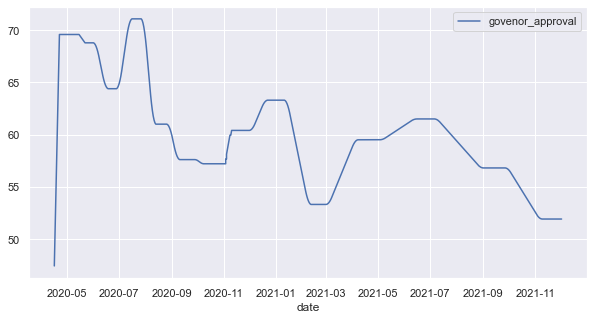

In [356]:
import matplotlib.pyplot as plt
gov_approval_df[gov_approval_df.state == 'New York'].set_index('date').plot(figsize=(10,5));

In [357]:
unemployment_df = pd.read_csv('/Users/sandaz/Downloads/state_unemployment.csv').melt(id_vars = ['date'], var_name='state', value_name='unemployment_rate')
unemployment_df.date = unemployment_df.date.apply(pd.to_datetime).dt.date
unemployment_df.unemployment_rate = unemployment_df.unemployment_rate.astype(float)
unemployment_df = unemployment_df[unemployment_df.date >= date(2020,3,1)]
unemployment_df

,date,state,unemployment_rate
530,2020-03-01,Alabama,2.8
531,2020-04-01,Alabama,12.7
532,2020-05-01,Alabama,7.6
533,2020-06-01,Alabama,8.0
534,2020-07-01,Alabama,7.9
...,...,...,...
28045,2021-06-01,Wyoming,5.6
28046,2021-07-01,Wyoming,4.4
28047,2021-08-01,Wyoming,3.7
28048,2021-09-01,Wyoming,2.7


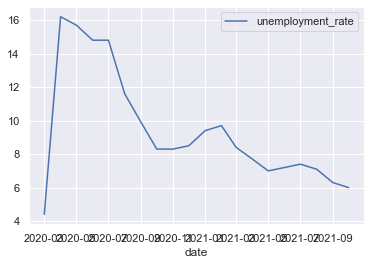

In [358]:
import matplotlib.pyplot as plt
unemployment_df[unemployment_df.state == 'New York'].set_index('date').plot();

In [359]:
govenor_party_df = pd.read_csv('/Users/sandaz/Downloads/govenor_party.csv')
govenor_party_df['is_gop'] = (govenor_party_df.Party == 'Republican').astype(int)
govenor_party_df['state'] = govenor_party_df.Office
govenor_party_df = govenor_party_df[['state', 'is_gop']]
govenor_party_df

In [360]:
def next_month_date(dt):
    return (dt.replace(day=1) + timedelta(days=32)).replace(day=1)


full_merged_df = pd.merge(masks, bars, on=['state', 'date'], how='inner')
full_merged_df = pd.merge(full_merged_df, rest, on=['state', 'date'], how='inner')
full_merged_df = pd.merge(full_merged_df, masks_school, on=['state', 'date'], how='inner')
full_merged_df = pd.merge(full_merged_df, masks_ban, on = ['state', 'date'], how = 'inner')
full_merged_df = pd.merge(full_merged_df, gov_approval_df, on = ['state', 'date'], how = 'inner')
merged_df = full_merged_df
merged_df.date = merged_df.date.apply(next_month_date)
merged_df = merged_df.groupby(by=['state', 'date']).mean() ##Add handling for the fact that unemployment rate 
merged_df = pd.merge(merged_df, unemployment_df, on = ['state', 'date'], how = 'inner')
merged_df = pd.merge(merged_df, govenor_party_df, on = ['state'], how = 'inner')
merged_df.loc[(merged_df.state == 'Montana') & (merged_df.date <= date(2021,1,4)), 'is_gop'] = 0
merged_df.date = merged_df.date.apply(pd.to_datetime)
merged_df.dtypes
merged_df[merged_df.date >= datetime(2020,5,1)]
merged_df = merged_df.set_index(['state', 'date'])

In [362]:
merged_df.to_csv('/Users/sandaz/cunycorn/gov_covid_data_w_schools.csv')

In [364]:
state_key = {s:i for i,s in enumerate(states)}
output_df = merged_df.reset_index()
output_df['state_code'] = output_df.state.apply(state_key.get)
output_df.reset_index().to_csv("/Users/sandaz/cunycorn/gov_covid_data_w_schools.csv")

In [30]:
state_key = {s:i for i,s in enumerate(states)}

In [96]:
election_df = pd.read_csv('/Users/sandaz/Downloads/incumbent_gov_margin_2020_2016.csv')
election_df

,state,2020 Incumbent Margin,2016 Incumbent Margin,Incumbent Margin Difference
0,Delaware,20.9,19.2,1.7
1,Indiana,24.4,6.0,18.4
2,Missouri,16.4,5.9,10.5
3,Montana,-12.8,3.9,-16.7
4,New Hampshire,31.7,2.3,29.4
5,North Carolina,4.5,37.4,-32.9
6,North Dakota,40.4,57.1,-16.7
7,Utah,32.7,38.1,-5.4
8,Vermont,41.1,8.8,32.3
9,Washington,13.5,8.8,4.7


In [374]:
election_df = pd.read_csv('/Users/sandaz/Downloads/incumbent_gov_margin_2020_2016.csv').rename(columns={'Incumbent Margin Difference':'incumbent_vote_margin_difference', '2020 Incumbent Margin':'incumbent_vote_margin'})
election_features = full_merged_df[['state', 'date', 'mask_mandate', 'bar_closed', 'restaurant_closed', 'masks_in_school', 'mask_mandates_banned']]
election_features = election_features[election_features.date <= date(2020,11,3)]
election_features = election_features.groupby(by=['state']).sum()
election_features_static = merged_df.reset_index()[['state', 'date', 'govenor_approval', 'unemployment_rate']]
election_features_static = election_features_static[election_features_static.date == datetime(2020,11,1)]
election_df = pd.merge(pd.merge(election_features, election_features_static, on='state', how='inner'), election_df, on='state', how='inner')[['state', 'incumbent_vote_margin_difference', 'incumbent_vote_margin', 'mask_mandate', 'bar_closed', 'restaurant_closed', 'masks_in_school', 'mask_mandates_banned', 'govenor_approval', 'unemployment_rate', 'is_gop']]
normalized_election_df=(election_df-election_df.mean())/election_df.std()
normalized_election_df

,state,incumbent_vote_margin_difference,incumbent_vote_margin,mask_mandate,bar_closed,restaurant_closed,masks_in_school,mask_mandates_banned,govenor_approval,unemployment_rate,is_gop
0,Delaware,1.7,20.9,187.0,61.0,47.0,0.0,0.0,47.076728,5.1,0
1,Indiana,18.4,24.4,97.0,58.0,33.0,0.0,0.0,48.852765,4.8,1
2,Missouri,10.5,16.4,0.0,19.0,19.0,0.0,0.0,40.658986,4.2,1
3,Montana,-16.7,-12.8,109.0,19.0,19.0,0.0,0.0,48.567512,4.3,0
4,New Hampshire,29.4,31.7,0.0,61.0,33.0,0.0,0.0,56.126959,4.0,1
5,North Carolina,-32.9,4.5,128.0,199.0,37.0,0.0,0.0,48.464286,6.3,0
6,North Dakota,-16.7,40.4,0.0,16.0,16.0,0.0,0.0,44.182028,4.3,1
7,Utah,-5.4,32.7,16.0,16.0,16.0,0.0,0.0,42.341014,3.2,1
8,Vermont,32.3,41.1,92.0,37.0,37.0,0.0,0.0,77.300922,3.2,1
9,Washington,4.7,13.5,128.0,79.0,79.0,0.0,0.0,53.586866,6.5,0


In [140]:
election_df.to_csv('/Users/sandaz/cunycorn/election_gov_covid.csv')
normalized_election_df.to_csv("/Users/sandaz/cunycorn/normalized_election_gov_covid.csv")

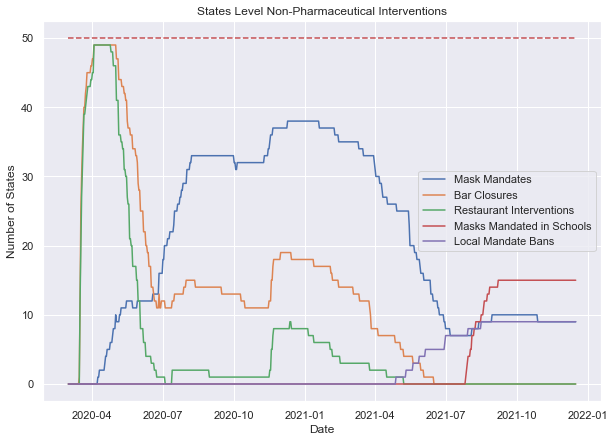

In [377]:
import seaborn as sns
sns.set_theme()
nlp_intervention_summary_df = nlp_intervention_df.groupby(by='date').sum()
nlp_intervention_summary_df['total'] = 50
# creating a dictionary
font = {'size': 25}
  
# using rc function
#plt.rc('font', **font)
#fig, ax = plt.subplots(figsize=(10,5))
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(nlp_intervention_summary_df['mask_mandate'], label='Mask Mandates')
ax.plot(nlp_intervention_summary_df['bar_closed'], label='Bar Closures')
ax.plot(nlp_intervention_summary_df['restaurant_closed'], label='Restaurant Interventions')
ax.plot(nlp_intervention_summary_df['masks_in_school'], label='Masks Mandated in Schools')
ax.plot(nlp_intervention_summary_df['mask_mandates_banned'], label='Local Mandate Bans')
ax.plot(nlp_intervention_summary_df['total'], 'r--')
ax.legend(loc='best')
ax.set_ylabel('Number of States')
ax.set_title('States Level Non-Pharmaceutical Interventions')
ax.set_xlabel('Date')
#ax.figure(figsize=(20, 10))
plt.show()
#plt.plot()

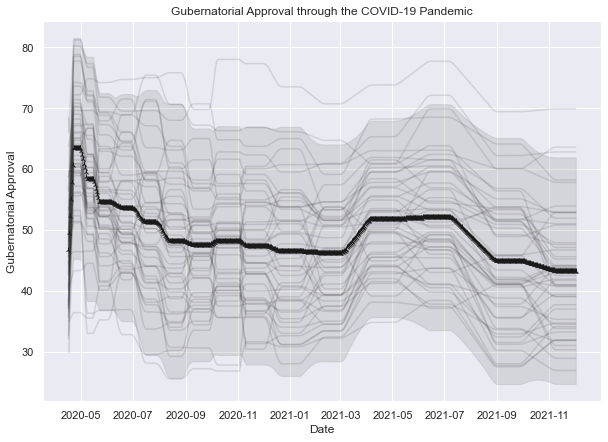

In [378]:
fig, ax = plt.subplots(figsize=(10,7))
for state in states:
    plt.plot(gov_approval_df[gov_approval_df.state == state].set_index(['date']).govenor_approval, 'k', alpha=0.12)


# gov_approval_df.groupby('date').var()    
plt.fill_between(gov_approval_df.date.unique(), (gov_approval_df.groupby('date').mean()-1.96*gov_approval_df.groupby('date').std()).govenor_approval, (gov_approval_df.groupby('date').mean()+1.96*gov_approval_df.groupby('date').std()).govenor_approval, color='grey', alpha=.2)
plt.plot(gov_approval_df.groupby('date').mean(), 'k2')
# p
# 
# 

ax.set_ylabel('Gubernatorial Approval')
ax.set_title('Gubernatorial Approval through the COVID-19 Pandemic')
ax.set_xlabel('Date')
plt.show()




